# Semantic Segmentation of Vertebrae
## Spinal Image Semantic Segmentation Using the MIDAS Dataset
### Special thanks to Dr. Julio Domenech; Dr. Antonio Alonso-Manjarrez.</a> - Hospital Arnau de Villanova

#### Acknowledgements: 
<a href="https://bimcv.cipf.es/bimcv-projects/project-midas/">Massive Image Data Anatomy Spine (MIDAS)</a>; 

<a href ="https://bimcv.cipf.es/"> Banco digital de Imagen Médica de la Comunidad Valenciana (BIMCV)</a>: "PhD (Machine Learning in Magnetic Resonance. Describing the Pathophysiology of Lumbar Pain)"

__email__ = jsaenz@cipf.es

__status__ = "PhD Candidate, UPV Valencia-Spain, Computer Science","Development, Biomedical Imaging Joint Unit, FISABIO-CIPF
Valencia, Spain"


## Introduction

This work addresses the problem of automatically segmenting the Magnetic Resonance images (MRI) corresponding to the lumbar spine.
The purpose is to detect and delimit the vertebrae. This task is known as semantic segmentation. The approach proposed in this work is based on convolutional neural networks whose output is a mask where each pixel from the input image is classified into one of the possible classes, Background or Vertebrae . 

The proposed network architecture is variant of the U-Net.

Index Terms — magnetic resonance images, convolutional neural networks, deep learning, image semantic segmentation

## Outline
<ul>
    <li>Hyperparameter Definition</li>
    <li>Loading data and creating a dataset for training and testing</li>
    <li>Modelling</li>
    <li>Evaluation</li>
    <li>Visualize Predictions</li>
</ul>


In [1]:
#! /usr/bin/python
# -*- coding: utf8 -*-
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# Imports
import sys, os, os.path, time
import pandas as pd
import platform 
print('python ' + platform.python_version())
import numpy as np
print('numpy ' + np.__version__)
import matplotlib
print('matplotlib ' + matplotlib.__version__)

from train_SpineSegmentation import load_parameters, train, test
sys.path.append('utils')
from load_data import get_data_paths

python 3.6.1
numpy 1.18.1
matplotlib 3.1.2


Using TensorFlow backend.


nibabel 3.0.0
tensorflow 2.1.0
keras 2.3.1

Num GPUs Available:  1


### Hyperparameter Definition

Below are the parameters, variables, paths and others that will be used in this task.

In [2]:
prm = load_parameters()
prm

{'MODEL_NAME': 'Unet2d_Opt-RMSprop_Lr-0.00033_Epoch-100_Filt-32',
 'VERBOSE': 1,
 'USE_BATCH_NORMALIZATION': True,
 'DROPOUT_P': 0.05,
 'N_FILTERS': 32,
 'PATIENCE': 5,
 'LR_GAMMA': 0.01,
 'OPTIMIZER': 'RMSprop',
 'LR': 0.00033,
 'CLASSIFIER_ACTIVATION': 'softmax',
 'LOSS': <keras.losses.CategoricalCrossentropy at 0x7f7190dde940>,
 'METRICS': [<keras.metrics.Recall at 0x7f7190de4be0>,
  <function segmentation_metrics.mean_iou(y_true, y_pred, **kwargs)>],
 'NUM_CLASS': 2,
 'DATA_AUGMENTATION_ONLINE': True,
 'IMAGE_SIZE': (256, 256),
 'BATCH_SIZE': 20,
 'MAX_EPOCH': 100,
 'VALIDATION_SIZE': 0.25,
 'TEST_SIZE': 0.2,
 'MODE': 'train',
 'MODEL_TYPE': 'Unet2d',
 'PARTITION_PATH': './dataset/subjects_partition.tsv',
 'STORE_PATH': './models/',
 'DATA_ROOT_PATH': '/nvmescratch/jsaenz/UC09/'}

## Loading data and creating a dataset for training and testing

The proposed CNN-based architectures were trained and evaluated by using a dataset which is a subset of the  <a href="https://bimcv.cipf.es/bimcv-projects/project-midas/">MIDAS corpus</a>. This corpus consists of MR images of lumbar scans extracted from the <a href ="https://bimcv.cipf.es/"> Medical Imaging Databank of the Valencian Region (BIMCV) database</a> , distributed among 17 health departments of the Valencian Region. A randomised subset of MR images from 100 study cases (patients) were manually segmented and annotated for the present work. The use of such images was approved by the local institutional ethics committee. The images were acquired at different hospitals. Both pathological and control images show the morphological changes typical of age, which are the result of adding different deformations derived from multiple pathologies (e.g. fractures, hernias, stenosis, osteophytes and others).

The manual semantic segmentation was carried out by two expert radiologists with a high expertise in skeletal muscle pathology. Sagittal
T2-weighted images were used to distinguish the anatomical silhouette of the different structural elements in the lumbar region. 

Due to cost, privacy restrictions, and the rarity of certain conditions, gathering medical datasets can be particularly challenging. Once gathered from disparate sources, these data will need to be standardized for training. 

The file structure for organising the dataset is MIDS, see: <a href="https://arxiv.org/abs/2010.00434">Medical imaging data structure extended to multiple modalities and anatomical regions (MIDS)</a>

The file:"./dataset/subjects_partition.tsv" Includes 100 MRIs to be used for this task. 
The code below examines our image set and organizes the filenames.

The columns of interest are:
<ul>
    <li>filepath : T2w MRI path</li>
    <li>manual_seg : manual segmentation path, ground truth</li>
    <li>test-xx :   test partition, comprising xx % of the total data set</li>
</ul>  


In [3]:
# We load the list of subjects, the list contains the paths of the subjects to be used for training and testing.
data = pd.read_csv(prm['PARTITION_PATH'], sep='\t', index_col=None)
data.head()

,subject,session,filepath,aut_seg,manual_seg,test-20,test-25,test-30
0,sub-S0023782,ses-E0025277,./sub-S0023782/ses-E0025277/mim-mr/anat/sub-S0...,./derivatives/aut_seg/sub-S0023782/ses-E002527...,./derivatives/manual_seg/sub-S0023782/ses-E002...,True,True,True
1,sub-S0014477,ses-E0015793,./sub-S0014477/ses-E0015793/mim-mr/anat/sub-S0...,./derivatives/aut_seg/sub-S0014477/ses-E001579...,./derivatives/manual_seg/sub-S0014477/ses-E001...,True,True,True
2,sub-S0012438,ses-E0013873,./sub-S0012438/ses-E0013873/mim-mr/anat/sub-S0...,./derivatives/aut_seg/sub-S0012438/ses-E001387...,./derivatives/manual_seg/sub-S0012438/ses-E001...,False,False,False
3,sub-S0057505,ses-E0062445,./sub-S0057505/ses-E0062445/mim-mr/anat/sub-S0...,./derivatives/aut_seg/sub-S0057505/ses-E006244...,./derivatives/manual_seg/sub-S0057505/ses-E006...,True,False,False
4,sub-S0057499,ses-E0062439,./sub-S0057499/ses-E0062439/mim-mr/anat/sub-S0...,./derivatives/aut_seg/sub-S0057499/ses-E006243...,./derivatives/manual_seg/sub-S0057499/ses-E006...,False,False,False


The experiments for each evaluated network architecture were done with the same validation. 20% of patients were used for test, the remaining 80% of patients used for training and validation.
The reported results were obtained with the test partitions.

The set of patients of each partition are disjoint sets. All 2-D images from one patient are samples of the same partition.

The training, validation and test partitions are divided in the following way

In [4]:
paths = get_data_paths(prm)

     Number of patients		2D-Images
Train:			60	747  
Test:			20	261  
Validation:		20	248


## Standardization of dataset

Standardization of datasets is a common requirement for many machine learning estimators; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

- Each MRI is standardised to zero mean and unit variance.


## Data Augmentation Online
In order to mitigate the overfitting problem, training data was randomly modified by the combination of several 2-D image transformations: <ul>
    <li>(a) random rotation up to ±20 degrees,</li>
    <li>(b) zoom in/out by a factor randomly selected from 0.5 to 1.5,</li>
    <li>(c) random shift in both axes up to 10% of height and width, and </li>
    <li>(d) horizontal flip.</li>
</ul> 

## Evaluation Metrics
<a href="https://ieeexplore.ieee.org/document/7478072">Intersection over Union</a> (IoU) was used as the metric to compare the performance of the evaluated network architectures. IoU is a variant of the Jaccard index to quantify the
overlapping between the ground-truth mask and the predicted mask.



## Modelling
The proposed network architecture is variant of the U-Net.

The U-Net, is a CNN that was created for semantic segmentation of small datasets of biomedical images from electron microscopes. The U-Net’s architecture was inspired by Fully Convolutional Networks for Semantic Segmentation. 

see:    
<a href="https://arxiv.org/pdf/1505.04597.pdf">U-Net: Convolutional Networks for Biomedical Image Segmentation</a> 
    
<a href ="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/">5 Minute Teaser Presentation of the U-net</a>

### Model architechture

In [5]:
# The following code, semantic segment an MRI image (T2 weighted image) in two class: Background and Vertebrae 
train(paths,prm)

Model: "Unet-2D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

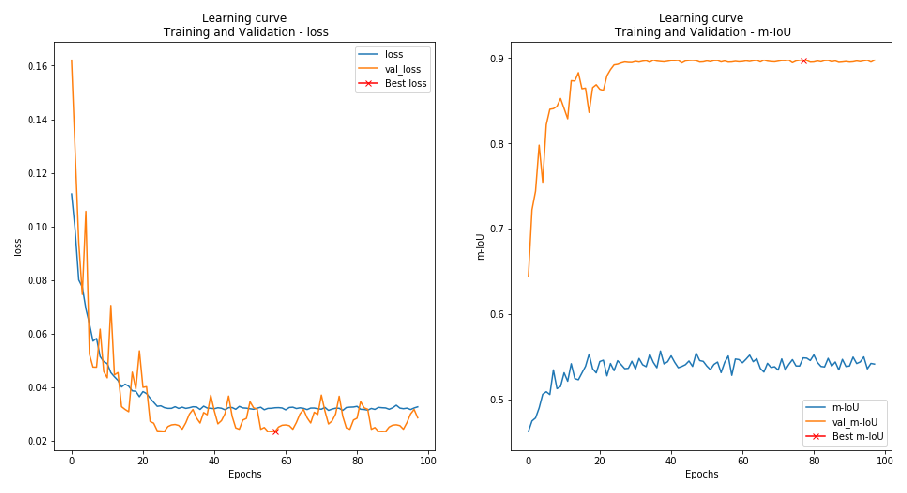

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpllimg
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

model_dir = os.path.join(prm["STORE_PATH"], prm['MODEL_NAME'])
img=mpllimg.imread(model_dir + '/Learning_curve.png')
plt.figure(figsize = (16,9))
plt.imshow(img)
plt.axis("off")
plt.show()

## Evaluation 

Carried out with the test partition 

In [7]:
prm = load_parameters()
test(paths,prm)



13/13 [==============================] - 9s 722ms/step

	Evaluate on test set

Loss: 0.051, Accuracy: 98.613%, mean_IoU: 85.929%


## Visualize Predictions
### Check if training data looks all right

In [8]:
from predict_SpineSegmentation import get_segmentation

In [9]:
nifty_path = str(paths['X_test'][0])

weights_path = os.path.join(model_dir,prm['MODEL_TYPE']+'-Model_Weights-best.h5')
model_path = os.path.join(model_dir,'model.json')
save_path = model_dir+'/' 
niftyGT_path = str(paths['y_test'][0])

In [10]:
segmentation = get_segmentation(nifty_path, model_path, weights_path, save_path, niftyGT_path)  
print('prediction shape: %s [slice][width][height][class]'%str(segmentation.shape))
print('class 0 = Background; class 1 = Vertebrae')

prediction shape: (12, 256, 256, 2) [slice][width][height][class]
class 0 = Background; class 1 = Vertebrae


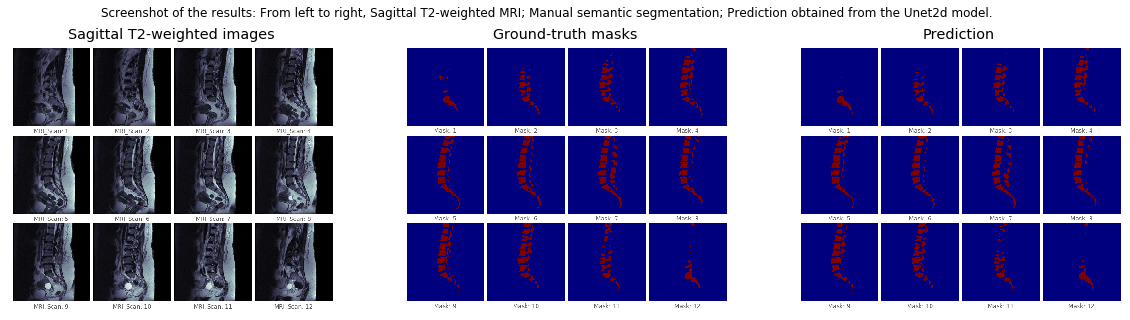

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

t2w=mpllimg.imread(model_dir + '/sub-S0012438_ses-E0013873_run-1_bp-lsspine_vp-sag_T2w_Screenshot-T2w.png')
pred=mpllimg.imread(model_dir + '/sub-S0012438_ses-E0013873_run-1_bp-lsspine_vp-sag_T2w_Screenshot-Vert.png')
gt=mpllimg.imread(model_dir + '/sub-S0012438_ses-E0013873_run-1_bp-lsspine_vp-sag_T2w_Screenshot-Vert_manual.png')

fig.suptitle('Screenshot of the results: From left to right, Sagittal T2-weighted MRI; Manual semantic segmentation; Prediction obtained from the %s model.'% prm['MODEL_TYPE'])
axs[0].imshow(t2w)
axs[0].axis("off")
axs[0].set_title('Sagittal T2-weighted images')
axs[1].imshow(gt)
axs[1].axis("off")
axs[1].set_title('Ground-truth masks')
axs[2].imshow(pred)
axs[2].axis("off")
axs[2].set_title('Prediction')
plt.show()
